# Funnel Target: Compare SGLD and Neural Wasserstein Gradient Flow of the KL

In [1]:
%load_ext autoreload
from jax import config
config.update("jax_debug_nans", True)
# config.update("jax_disable_jit", True)

import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning/")
from matplotlib.animation import FuncAnimation

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import matplotlib
import numpy as onp
import jax
import pandas as pd

import utils
import plot
import distributions
import models
import flows
from tqdm import tqdm
key = random.PRNGKey(0)

import kernels
import metrics

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
# set up exporting
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
    'pgf.rcfonts': False,
})

figure_path = "/home/lauro/documents/msc-thesis/thesis/figures/"
# save figures by using plt.savefig('path/to/fig')
# remember that latex textwidth is 5.4in
# so use figsize=[5.4, 4], for example
printsize = [5.4, 4]

# 2dim Funnel

In [41]:
%autoreload

In [42]:
%matplotlib inline

In [43]:
n_steps = 4000
particle_lr = 1e-2
learner_lr = 1e-3
n_particles = 200
d = 2
PATIENCE = 0
# PATIENCE = 15 # try this

In [44]:
target = distributions.Funnel(d)
proposal = distributions.Gaussian(np.zeros(d), np.ones(d))
funnel_setup = distributions.Setup(target, proposal)

In [45]:
%autoreload

In [74]:
key, subkey = random.split(key)
neural_learner, neural_particles, err1 = flows.neural_svgd_flow(subkey, funnel_setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, patience=PATIENCE, learner_lr=learner_lr, aux=False)
svgd_gradient, svgd_particles, err2    = flows.svgd_flow(       subkey, funnel_setup, n_particles=200, n_steps=n_steps, particle_lr=particle_lr, scaled=True,  bandwidth=None)
sgld_gradient, sgld_particles, err3    = flows.sgld_flow(       subkey, funnel_setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr)
sgld_gradient2, sgld_particles2, err4    = flows.sgld_flow(     subkey, funnel_setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr/20)

100%|██████████| 4000/4000 [00:24<00:00, 161.58it/s]


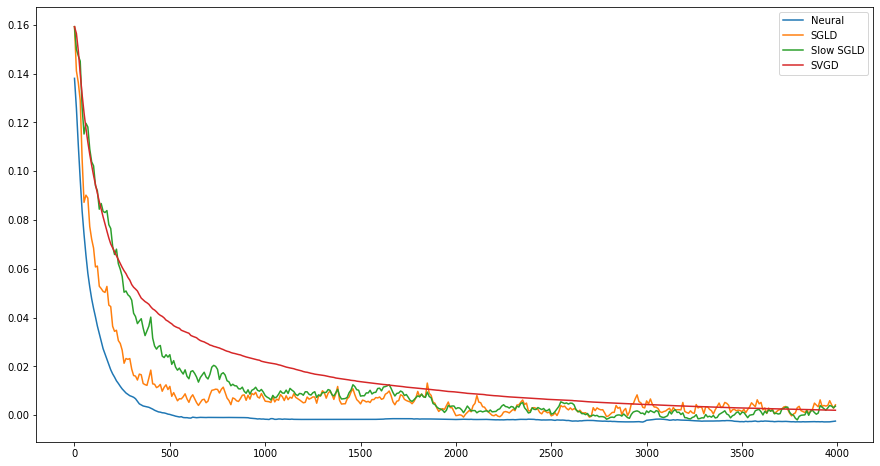

In [47]:
plt.subplots(figsize=[15, 8])

plt.plot(*zip(*neural_particles.rundata["mmd"]), label="Neural")
plt.plot(*zip(*sgld_particles.rundata["mmd"]), label="SGLD")
# plt.plot(*zip(*sgld_particles2.rundata["mmd"]), label="Slow SGLD")
plt.plot(*zip(*svgd_particles.rundata["mmd"]), label="SVGD")

plt.legend()

In [75]:
plt.subplots(figsize=printsize)

plt.plot(*zip(*neural_particles.rundata["mmd"]), label="Neural")
plt.plot(*zip(*sgld_particles.rundata["mmd"]), label="SGLD")
# plt.plot(*zip(*sgld_particles2.rundata["mmd"]), label="Slow SGLD")
plt.plot(*zip(*svgd_particles.rundata["mmd"]), label="SVGD")
plt.legend()

plt.savefig(figure_path + "funnel_mmd.pgf")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [76]:
true_samples = target.sample(n_particles)
def plot_true(idx=np.array([0, -1]), ax=None):
    if ax is None:
        ax = plt.gca()
    lims=(-15, 15)
    ax.set(xlim=lims, ylim=lims)
    ax.scatter(*np.rollaxis(true_samples[:, idx], 1), alpha=0.25, label="True")

In [79]:
def plot_projection(idx, figsize=[20, 5]):
    sample_list = [p.particles.training for p in (neural_particles, sgld_particles, sgld_particles2)]
    fig, axs = plt.subplots(1, 3, figsize=figsize)
    titles = ("Neural SVGD", "Langevin", "Langevin (smaller stepsize)")
    for samples, ax, title in zip(sample_list, axs.flatten(), titles):
        print(samples.shape)
        plot_true(idx, ax)
        ax.scatter(*np.rollaxis(samples[:, idx], 1), alpha=0.55)
        ax.legend()
        ax.set_title(title)
        ax.set(xlim=lims, ylim=lims)

(200, 2)
(200, 2)
(200, 2)


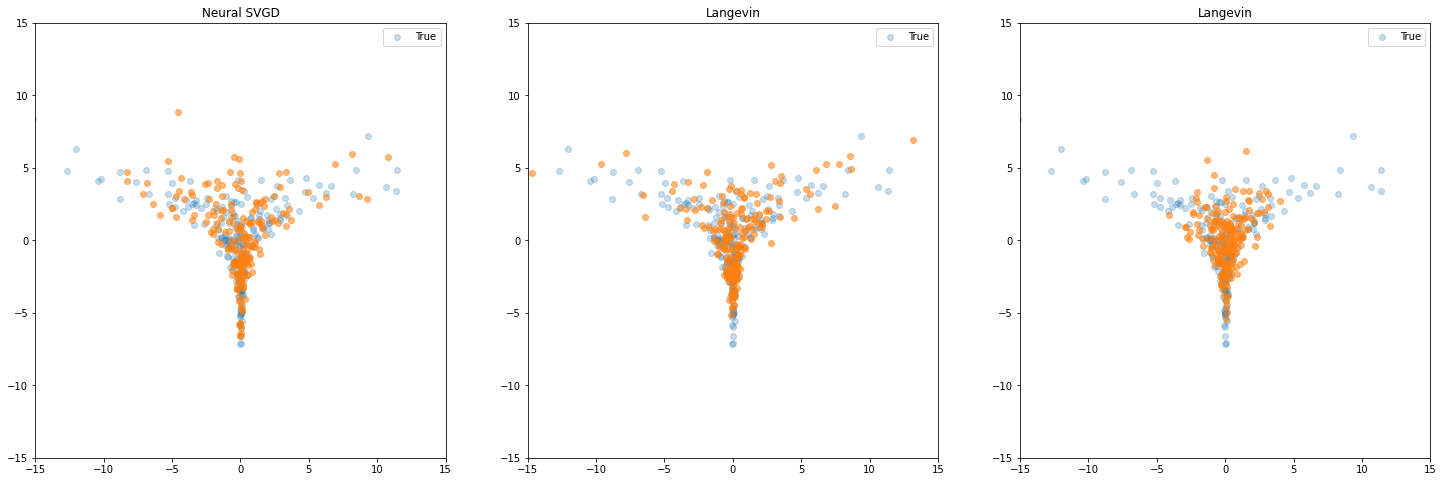

In [78]:
%matplotlib inline
lims=(-15, 15)

idx = np.array([0, -1])
plot_projection(idx, figsize=[25, 8])

(200, 2)
(200, 2)
(200, 2)


ValueError: Error processing '−10'
LaTeX Output:

! Package inputenc Error: Unicode character − (U+2212)
(inputenc)                not set up for use with LaTeX.

See the inputenc package documentation for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
<*> ...ize{10.000000}{12.000000}\selectfont −10}
                                                  
!  ==> Fatal error occurred, no output PDF file produced!
Transcript written on texput.log.


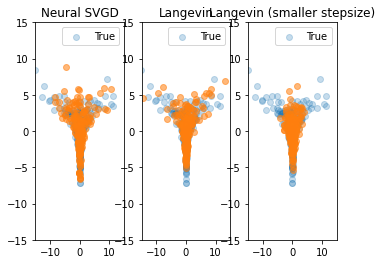

In [80]:
idx = np.array([0, -1])
plot_projection(idx, figsize=printsize)
plt.savefig(figure_path + "funnel_scatter.pgf")

In [52]:
# fig, axs = plt.subplots(1, 2, figsize=[15, 7])
# for ax in axs:
#     plot.scatter(vmap(kernels.defunnelize)(true_samples), ax=ax)
#     ax.set(ylim=[-3, 3], xlim=[-3, 3])

# plot.scatter(vmap(kernels.defunnelize)(neural_particles.particles.training), ax = axs[0])
# plot.scatter(vmap(kernels.defunnelize)(sgld_particles.particles.training), ax = axs[1])

# mmd = jit(metrics.get_mmd(kernels.get_funnel_kernel(1.)))

# true_samples = target.sample(n_particles*10)

# mmd(*[samples for samples in (neural_particles.particles.training, true_samples)])

# mmd(*[samples for samples in (sgld_particles.particles.training, true_samples)])

### neural metrics

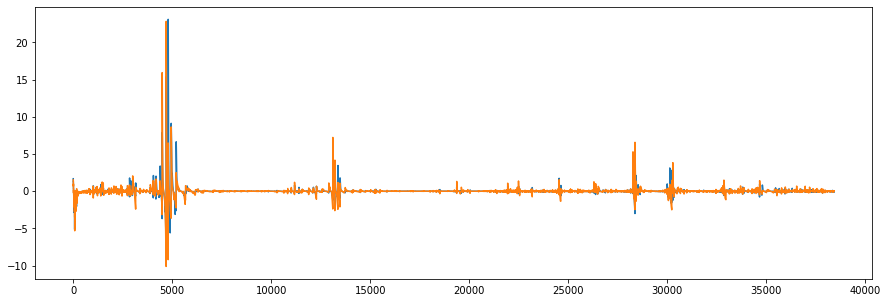

In [58]:
%matplotlib inline
plt.subplots(figsize=[15, 5])
plt.plot(neural_learner.rundata["training_loss"])
plt.plot(neural_learner.rundata["validation_loss"])

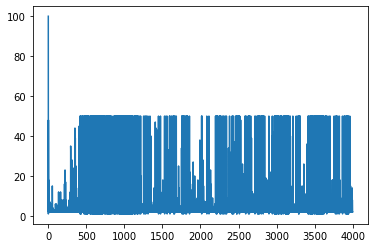

In [59]:
%matplotlib inline
plt.plot(neural_learner.rundata["train_steps"])

### animate projection

In [60]:
idx = np.array([0, -1])

In [61]:
neural_particles.rundata.keys()

dict_keys(['particles', 'step', 'test_mean', 'test_std', 'training_mean', 'training_std', 'mmd'])

In [62]:
trajectory = neural_particles.rundata["particles"].training
trajectory_projected = trajectory[:, :, idx]


In [73]:
%matplotlib widget
lims = (-15, 15)
fig, axs = plt.subplots(1, 3, figsize=[25,8])
for ax in axs:
    ax.scatter(*np.rollaxis(target.sample(n_particles)[:, idx], 1), label="True", alpha=0.25)
    ax.set(xlim=lims, ylim=lims)

    
interval = 10
a=[]
a.append(plot.animate_array(trajectory_projected, fig, ax=axs[0], interval=interval))
a.append(plot.animate_array(sgld_particles.rundata["particles"].training, ax=axs[1], interval=interval))
a.append(plot.animate_array(sgld_particles2.rundata["particles"].training, ax=axs[2], interval=interval))
a

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Same thing with `TFP`

In [26]:
key, subkey = random.split(key)

In [27]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

In [28]:
d = 2
dfunnel = distributions.Funnel(d)
dproposal = distributions.Gaussian(np.ones(d), 1)
target_log_prob = dfunnel.logpdf

# kernel = tfp.mcmc.MetropolisAdjustedLangevinAlgorithm(target_log_prob_fn=target_log_prob, step_size=1e-2)
# kernel = tfp.mcmc.NoUTurnSampler(target_log_prob, 1e-3)
kernel = tfp.mcmc.UncalibratedLangevin(target_log_prob_fn=target_log_prob, step_size=5e-4)

@jit
def run_chain(key, state):
    return tfp.mcmc.sample_chain(50000,
      current_state=state,
      kernel=kernel,
      trace_fn = None,
#       trace_fn=lambda _, results: results.target_log_prob,
      num_burnin_steps=0,
      seed=key)

In [29]:
# m = n_particles
m = 500
key, subkey = random.split(key)
init_state = dproposal.sample(m, subkey)

In [30]:
vstates = vmap(run_chain)(random.split(subkey, m), init_state)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/tensorflow_probability/substrates/jax/mcmc/sample.py:327: UserWarning: supplied `TransitionKernel` is not calibrated. Markov chain may not converge to intended target distribution.
  warnings.warn('supplied `TransitionKernel` is not calibrated. Markov '


In [31]:
idx = np.array([0, -1])

In [32]:
fig, ax = plt.subplots(figsize=[8,8])
plot_true()
plot.scatter(vstates[:, -1, idx])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

AttributeError: __delete__

<Figure size 576x576 with 1 Axes>

In [33]:
fig, ax = plt.subplots(figsize=[8,8])
plot_true()
plot.animate_array(np.rollaxis(vstates, 1)[:, :, idx], ax=ax, interval=1)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

AttributeError: __delete__

<Figure size 576x576 with 1 Axes>

# same thing in 3D

In [34]:
sldfjlkj

NameError: name 'sldfjlkj' is not defined

In [ ]:
n_steps = 500
particle_lr = 1e-2
learner_lr = 1e-3
n_particles = 1000
d = 10
PATIENCE = 0
# PATIENCE = 15 # try this

In [ ]:
target = distributions.Funnel(d)
proposal = distributions.Gaussian(np.zeros(d), np.ones(d))
funnel_setup = distributions.Setup(target, proposal)

In [ ]:
key, subkey = random.split(key)
neural_learner, neural_particles, err1 = flows.neural_svgd_flow(subkey, funnel_setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=0., patience=PATIENCE, learner_lr=learner_lr, aux=False)
sgld_gradient, sgld_particles, err3    = flows.sgld_flow(       subkey, funnel_setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=1.)
sgld_gradient2, sgld_particles2, err4    = flows.sgld_flow(       subkey, funnel_setup, n_particles=n_particles, n_steps=n_steps*10, particle_lr=particle_lr/10, noise_level=1.)

In [ ]:
def plot_projection(idx, figsize=[20, 5]):
    true_samples = target.sample(n_particles)
    sample_list = [p.particles.training for p in (neural_particles, sgld_particles, sgld_particles2)]
    fig, axs = plt.subplots(1, 3, figsize=figsize)
    titles = ("Neural SVGD", "Langevin", "Langevin")
    for samples, ax, title in zip(sample_list, axs.flatten(), titles):
        ax.scatter(*np.rollaxis(true_samples[:, idx], 1), alpha=0.15, label="True")
        ax.scatter(*np.rollaxis(samples[:, idx], 1), alpha=0.55)
        ax.legend()
        ax.set_title(title)
        ax.set(xlim=lims, ylim=lims)

In [ ]:
%matplotlib inline
lims=(-15, 15)

idx = np.array([0, -1])
plot_projection(idx, figsize=[25, 8])

### neural metrics

In [ ]:
%matplotlib inline
plt.subplots(figsize=[15, 5])
plt.plot(neural_learner.rundata["training_loss"])
plt.plot(neural_learner.rundata["validation_loss"])

In [ ]:
%matplotlib inline
plt.plot(neural_learner.rundata["train_steps"])

### animate projection

In [ ]:
idx = np.array([0, -1])

In [ ]:
neural_particles.rundata.keys()

In [ ]:
%matplotlib widget
lims = (-15, 15)
fig, axs = plt.subplots(1, 3, figsize=[25,8])
projected_sample = target.sample(n_particles)[:, idx]
for ax in axs:
    ax.scatter(*np.rollaxis(projected_sample, 1), label="True", alpha=0.25)
    ax.set(xlim=lims, ylim=lims)

a=[]
a.append(plot.animate_array(neural_particles.rundata["particles"].training[:, :, idx], fig, ax=axs[0], interval=10**2))
a.append(plot.animate_array(sgld_particles.rundata["particles"].training[:, :, idx],   fig, ax=axs[1], interval=10**2))
a.append(plot.animate_array(sgld_particles2.rundata["particles"].training[:, :, idx],  fig, ax=axs[2], interval=10**2))
a